In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

In [ ]:
! kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

In [ ]:
mkdir /root/.kaggle/

In [ ]:
mv /content/kaggle.json /root/.kaggle/

In [ ]:
! unzip /content/lgg-mri-segmentation.zip

In [16]:
! pip install torchsummary

In [ ]:
! rm -rf *.txt

In [17]:
import os
import numpy as np
import pandas as pd
import cv2 
import matplotlib.pyplot as plt 
from glob import glob
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as ff
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torchvision import models
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

# Dataset

In [ ]:

# data_dir = "/content/kaggle_3m"   
data_dir = "../input/lgg-mri-segmentation/kaggle_3m"


images_dir = []
masks_dir = []
masks_dir = glob(data_dir + '/*/*_mask*')

for i in masks_dir:
    images_dir.append(i.replace('_mask',''))

print("totalimages{}, image_names{}".format(len(images_dir), images_dir[:2]))
print("masklengths{}, masknames{}".format(len(masks_dir), masks_dir[:2]))

In [19]:
data = pd.DataFrame({'images':images_dir,'masks':masks_dir})
data

,images,masks
0,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
1,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
2,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
3,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
4,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
...,...,...
3924,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
3925,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
3926,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
3927,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...


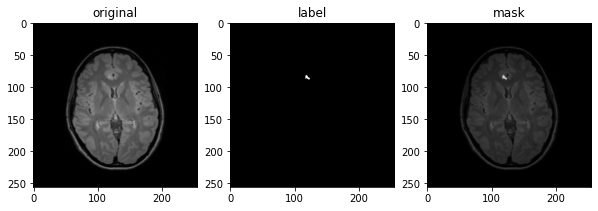

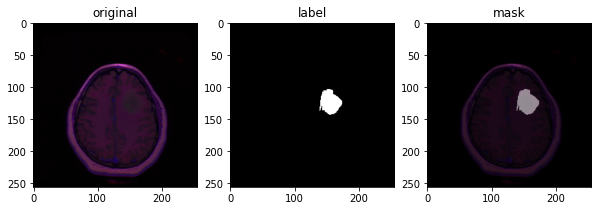

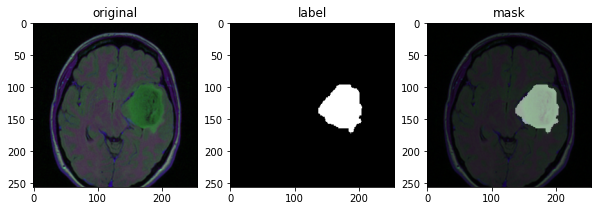

In [59]:

pic_list=[265,895,95]
for N in pic_list:
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    img = cv2.imread(data.images.iloc[N])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.title("original")
    plt.imshow(img)
    plt.subplot(1,3,2)
    msk=cv2.imread(data.masks.iloc[N])
    msk = cv2.cvtColor(msk, cv2.COLOR_BGR2RGB)
    plt.title("label")
    plt.imshow(msk)
    plt.subplot(1,3,3)
    plt.title("mask")
    plt.imshow(img)
    plt.imshow(msk,alpha=0.5)

In [60]:
a = cv2.imread(data.masks.iloc[95])
a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)

In [61]:
print(a.shape)

(256, 256, 3)


In [62]:
# 查看值得分布
msk=cv2.imread(data.masks.iloc[95])
print(msk.shape)
print(np.unique(msk))

(256, 256, 3)
[  0 255]


## 对label编码

In [63]:
class LabelProcessor:

    def __init__(self):
        self.colormap = self.read_color_map()
        self.cm2lbl = self.encode_label_pix(self.colormap)
    
    def encode_label_img(self, img):
        data = np.array(img, dtype='int32')
        idx = (data[:, :, 0] * 256 + data[:, :, 1]) * 256 + data[:, :, 2]
        return np.array(self.cm2lbl[idx], dtype='int64')
    
    @staticmethod
    def read_color_map():  
        colormap = []
        colormap.append([0,0,0])
        colormap.append([255,255,255])
        return colormap
    
    @staticmethod
    def encode_label_pix(colormap):     
        cm2lbl = np.zeros(256 ** 3)
        for i, cm in enumerate(colormap):
            cm2lbl[(cm[0] * 256 + cm[1]) * 256 + cm[2]] = i
        return cm2lbl

## pytorch dataset

In [64]:
class MRIDataset(Dataset):
    
    def __init__(self, img_path, label_path):

        if not isinstance(img_path, np.ndarray):
            self.img_path = img_path.to_numpy()
            self.label_path = label_path.to_numpy()
        self.labelProcessor = LabelProcessor()

    def __getitem__(self, index):
        img = self.img_path[index]
        label = self.label_path[index]
      
        img = cv2.imread(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = cv2.imread(label)
        label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)
        # transform
        img, label = self.img_transform(img, label)

        return {'img': img, 'label': label}

    def __len__(self):
        return len(self.img_path)

    def img_transform(self, img, label):
        
        transform_img = transforms.Compose([transforms.ToTensor(),  #
                                            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
        
        img = transform_img(img)
        label = self.labelProcessor.encode_label_img(label)
        label = torch.from_numpy(label)

        return img, label

In [65]:
a = MRIDataset(data["images"], data["masks"])
a[0]["img"].shape

torch.Size([3, 256, 256])

# FCN

In [66]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [67]:
import numpy as np
import torch
from torchvision import models
from torch import nn


class FCN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        pretrained_net = models.vgg16_bn(pretrained=True)
        self.stage1 = pretrained_net.features[:7]
        self.stage2 = pretrained_net.features[7:14]
        self.stage3 = pretrained_net.features[14:24]
        self.stage4 = pretrained_net.features[24:34]
        self.stage5 = pretrained_net.features[34:]

        self.scores1 = nn.Conv2d(512, num_classes, 1)
        self.scores2 = nn.Conv2d(512, num_classes, 1)
        self.scores3 = nn.Conv2d(128, num_classes, 1)

        self.conv_trans1 = nn.Conv2d(512, 256, 1)
        self.conv_trans2 = nn.Conv2d(256, num_classes, 1)

        self.upsample_8x = nn.ConvTranspose2d(num_classes, num_classes, 16, 8, 4, bias=False)
        # self.upsample_8x.weight.data = bilinear_kernel(num_classes, num_classes, 16)

        self.upsample_2x_1 = nn.ConvTranspose2d(512, 512, 4, 2, 1, bias=False)
        # self.upsample_2x_1.weight.data = bilinear_kernel(512, 512, 4)

        self.upsample_2x_2 = nn.ConvTranspose2d(256, 256, 4, 2, 1, bias=False)
        # self.upsample_2x_2.weight.data = bilinear_kernel(256, 256, 4)

    def forward(self, x):
        s1 = self.stage1(x)
        s2 = self.stage2(s1)
        s3 = self.stage3(s2)
        s4 = self.stage4(s3)
        s5 = self.stage5(s4)

        scores1 = self.scores1(s5)
        s5 = self.upsample_2x_1(s5)
        add1 = s5 + s4

        scores2 = self.scores2(add1)

        add1 = self.conv_trans1(add1)
        add1 = self.upsample_2x_2(add1)
        add2 = add1 + s3

        output = self.conv_trans2(add2)
        output = self.upsample_8x(output)
        return output


if __name__ == "__main__":
    import torch as t
    print('-----'*5)
    rgb = t.randn(1, 3, 32, 32)

    net = FCN(2)

    out = net(rgb)
    

-------------------------


# evaluation

In [68]:
a,b= np.array([1,2,3,4]).reshape(2,2)

In [69]:
y,u = a

In [70]:
confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0])

array([[0, 2],
       [1, 1]])

In [71]:
from __future__ import division
from sklearn.metrics import confusion_matrix
import numpy as np
import six


def calc_semantic_segmentation_confusion(pred_labels, gt_labels):
    pred_labels = pred_labels.flatten()
    gt_labels = gt_labels.flatten()
    confusion = confusion_matrix(gt_labels, pred_labels)
    if len(confusion)!= 2:
        confusion =  np.array([confusion[0][0],0,0,0]).reshape(2,2)
    return confusion


def calc_semantic_segmentation_iou(confusion):
    intersection = np.diag(confusion)
    union = np.sum(confusion, axis=1) + np.sum(confusion, axis=0) - np.diag(confusion)
    Ciou = (intersection / (np.maximum(1.0, union)+  1e-10) )
    mIoU = np.nanmean(Ciou)
    return mIoU

def calc_semantic_segmentation_dice(confusion):
    a, b = confusion
    tn, fp = a
    fn, tp = b
    return np.nanmean(2*tp/(2*tp + fn + fp+  1e-10))

def eval_semantic_segmentation(pred_labels, gt_labels):
    confusion = calc_semantic_segmentation_confusion(pred_labels, gt_labels)
    mIoU = calc_semantic_segmentation_iou(confusion) 
    pixel_accuracy = np.nanmean(np.diag(confusion) / (confusion.sum(axis=1)+1e-10))
    class_accuracy = np.diag(confusion) / ( confusion.sum(axis=1) +  1e-10 )
    dice = calc_semantic_segmentation_dice(confusion)

    return {'miou': mIoU,
            'pixel_accuracy': pixel_accuracy,
            'class_accuracy': class_accuracy,
            'dice': dice}

In [72]:
rgb = t.randn(1, 3, 64, 64)
net = FCN(2)
out = net(rgb)
print(out.shape)

torch.Size([1, 2, 64, 64])


In [73]:
out = F.log_softmax(out, dim=1)
out = out.max(dim=1)[1].data.cpu().numpy()
true_label = torch.randint(0,2,(1,64,64)).numpy()

In [74]:
eval_semantic_segmentation(out,true_label)

{'miou': 0.3306375204996559,
 'pixel_accuracy': 0.49774706918614625,
 'class_accuracy': array([0.52723638, 0.46825776]),
 'dice': 0.48781700646443343}

# train

In [75]:

from sklearn.model_selection import train_test_split

train, test = train_test_split(data,test_size=0.2, shuffle=True, random_state=233)

device = t.device('cuda') if t.cuda.is_available() else t.device('cpu')
num_class = 2

Load_train = MRIDataset(train["images"], train["masks"])
Load_val= MRIDataset(test["images"], test["masks"])

train_data = DataLoader(Load_train, batch_size=4, shuffle=True, num_workers=1)
val_data = DataLoader(Load_val, batch_size=4, shuffle=True, num_workers=1)

In [76]:
fcn = FCN(num_class)
fcn = fcn.to(device)
criterion = nn.NLLLoss().to(device)
optimizer = optim.Adam(fcn.parameters(), lr=1e-4)

In [77]:
def evaluate(model):
    model = model.eval()
    num_class = 2
    eval_loss = 0
    eval_acc = 0
    eval_miou = 0
    eval_class_acc = 0
    eval_dice = 0
    error = 0

    for j, sample in enumerate(val_data):
        valImg = sample['img'].to(device)
        valLabel = sample['label'].long().to(device)
        
        out = model(valImg)
        out = F.log_softmax(out, dim=1)
        loss = criterion(out, valLabel)
        eval_loss = loss.item() + eval_loss
        
        
        pre_label = out.max(dim=1)[1].data.cpu().numpy()
        true_label = valLabel.data.cpu().numpy()
        eval_metrics = eval_semantic_segmentation(pre_label, true_label)
        eval_acc = eval_metrics['pixel_accuracy'] + eval_acc
        eval_miou = eval_metrics['miou'] + eval_miou

        eval_class_acc =  eval_metrics['class_accuracy'] + eval_class_acc
        eval_dice = eval_metrics['dice'] + eval_dice

    val_str = '|val Acc|: {:.5f}\n|val dice|: {:.5f}\n|val Mean IoU|: {:.5f}\n|val_class_acc|: {:}'.format(
        eval_acc / len(val_data),
        eval_dice / len(val_data),
        eval_miou / len(val_data),
        eval_class_acc / (len(val_data)-error))
    print(val_str)
    
    return eval_acc / len(val_data), eval_dice / len(val_data), eval_miou / len(val_data), eval_class_acc / (len(val_data)-error)

In [78]:
net = fcn.train()

best = [0]
Epoch = 30
train_acc_epoch = []
train_miou_epoch = []
train_dice_epoch = []
train_class_acc_epoch = []

test_acc_epoch = []
test_miou_epoch = []
test_dice_epoch = []
test_class_acc_epoch = []

for epoch in range(Epoch):
    
    train_loss = 0
    train_acc = 0
    train_miou = 0
    train_dice = 0
    train_class_acc = 0
    error = 0
    print('Epoch is [{}/{}]'.format(epoch + 1, Epoch))

    for i, sample in enumerate(train_data):
        
        img_data = sample['img'].to(device)
        img_label = sample['label'].to(device)
        
        out = net(img_data)
        out = F.log_softmax(out, dim=1)
        loss = criterion(out, img_label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        pre_label = out.max(dim=1)[1].data.cpu().numpy()
        true_label = img_label.data.cpu().numpy()
        eval_metrix = eval_semantic_segmentation(pre_label, true_label)
        train_acc += eval_metrix['pixel_accuracy']
        train_miou += eval_metrix['miou']
        if len(eval_metrix['class_accuracy']) < num_class:
            eval_metrix['class_accuracy'] = 0
            train_class_acc = train_class_acc + eval_metrix['class_accuracy']
            error += 1
        else:
            train_class_acc = train_class_acc + eval_metrix['class_accuracy']
        train_dice += eval_metrix['dice']
        
        if i%500 ==0:
            print('|batch[{}/{}]|batch_loss:{:.9f}|'.format(i + 1, len(train_data), loss.item()))

    metric_description = '|Train Acc|: {:.5f}\n|Train dice|: {:.5f}\n|Train Mean IoU|: {:.5f}\n|Train_class_acc|: {:}'.format(
        train_acc / len(train_data),
        train_dice / len(train_data),
        train_miou / len(train_data),
        train_class_acc / (len(train_data)-error))


    print(metric_description)
    print("-----------------")
    test_acc, test_dice, test_miou, test_class_acc = evaluate(net)
    print("-----------------")
    
    test_acc_epoch.append(test_acc)
    test_miou_epoch.append(test_miou)
    test_dice_epoch.append(test_dice)
    test_class_acc_epoch.append(test_class_acc)

    train_acc_epoch.append(train_acc / len(train_data))
    train_miou_epoch.append(train_miou / len(train_data))
    train_dice_epoch.append(train_dice / len(train_data))
    train_class_acc_epoch.append(list(train_class_acc / (len(train_data)-error)))

    
    if max(best) <= test_dice:
        best.append(test_dice)
        t.save(net.state_dict(), './{}.pth'.format(epoch))
        


Epoch is [1/30]
|batch[1/786]|batch_loss:0.693597436|
|batch[501/786]|batch_loss:0.027117340|
|Train Acc|: 0.72049
|Train dice|: 0.44386
|Train Mean IoU|: 0.65719
|Train_class_acc|: [0.96912192 0.47184892]
-----------------
|val Acc|: 0.74539
|val dice|: 0.54377
|val Mean IoU|: 0.71816
|val_class_acc|: [0.99882528 0.49195659]
-----------------
Epoch is [2/30]
|batch[1/786]|batch_loss:0.000764240|
|batch[501/786]|batch_loss:0.021618260|
|Train Acc|: 0.75814
|Train dice|: 0.52667
|Train Mean IoU|: 0.71208
|Train_class_acc|: [0.99832916 0.51794821]
-----------------
|val Acc|: 0.79483
|val dice|: 0.59898
|val Mean IoU|: 0.75097
|val_class_acc|: [0.99838136 0.5912734 ]
-----------------
Epoch is [3/30]
|batch[1/786]|batch_loss:0.000129717|
|batch[501/786]|batch_loss:0.010443252|
|Train Acc|: 0.80119
|Train dice|: 0.61094
|Train Mean IoU|: 0.75748
|Train_class_acc|: [0.99853488 0.60384793]
-----------------
|val Acc|: 0.79534
|val dice|: 0.57686
|val Mean IoU|: 0.72661
|val_class_acc|: [0.9

In [79]:
len(train_class_acc_epoch)

30

In [80]:
test_dice_epoch

[0.5437674285738288,
 0.5989765337628207,
 0.5768641165213569,
 0.6382266223085005,
 0.6614654785729172,
 0.6341867929975235,
 0.7079817182914919,
 0.6850516001338597,
 0.7198379563284841,
 0.6915522000255522,
 0.7039241970378138,
 0.6883884435745523,
 0.6773142862870674,
 0.7095554746998244,
 0.6576323696663466,
 0.6982134910070635,
 0.7095604541356072,
 0.7073140193361892,
 0.6998025270593621,
 0.6906936953349988,
 0.6385713548179544,
 0.6806058655238096,
 0.7149278804280403,
 0.6867446793563529,
 0.7316323025239072,
 0.7223730456526475,
 0.4697993727242997,
 0.7148984702847154,
 0.7013996599517982,
 0.704817243673294]

# validation

In [81]:
device = t.device('cuda') if t.cuda.is_available() else t.device('cpu')

BATCH_SIZE = 4
miou_list = [0]

In [82]:
val_data

In [83]:
net = FCN(num_class)
net.to(device)
net.load_state_dict(t.load('24.pth'))

<All keys matched successfully>

In [84]:
train_acc = 0
train_miou = 0
train_class_acc = 0
train_mpa = 0
error = 0


In [87]:
def evaluate(model):
    net = model.eval()
    num_class = 2
    eval_loss = 0
    eval_acc = 0
    eval_miou = 0
    eval_class_acc = 0
    eval_dice = 0
    error = 0

    for j, sample in enumerate(val_data):
        valImg = sample['img'].to(device)
        valLabel = sample['label'].long().to(device)
        
        out = net(valImg)
        out = F.log_softmax(out, dim=1)
        loss = criterion(out, valLabel)
        eval_loss = loss.item() + eval_loss
        
        # 评估
        pre_label = out.max(dim=1)[1].data.cpu().numpy()
        true_label = valLabel.data.cpu().numpy()
        eval_metrics = eval_semantic_segmentation(pre_label, true_label)
        eval_acc = eval_metrics['pixel_accuracy'] + eval_acc
        eval_miou = eval_metrics['miou'] + eval_miou

        eval_class_acc =  eval_metrics['class_accuracy'] + eval_class_acc
        eval_dice = eval_metrics['dice'] + eval_dice

    val_str = '|val Acc|: {:.5f}\n|val dice|: {:.5f}\n|val Mean IoU|: {:.5f}\n|val_class_acc|: {:}'.format(
        eval_acc / len(val_data),
        eval_dice / len(val_data),
        eval_miou / len(val_data),
        eval_class_acc / (len(val_data)-error))
    print(val_str)

In [88]:
evaluate(net)

|val Acc|: 0.84997
|val dice|: 0.71704
|val Mean IoU|: 0.82111
|val_class_acc|: [0.99911364 0.70083292]


# predict

In [89]:
colormap = []
colormap.append([0,0,0])
colormap.append([255,255,255])
cm = np.array(colormap).astype('uint8')

In [90]:
test_img = test["images"].to_numpy()[22:32]
test_label = test["masks"].to_numpy()[22:32]
pd_aa = pd.DataFrame({'images':test_img,'masks':test_label})
Load_val= MRIDataset(pd_aa['images'], pd_aa['masks'])
val_data = DataLoader(Load_val, batch_size=10, shuffle=False, num_workers=1)

In [91]:
smaples = iter(val_data)
sample = smaples.next()

In [92]:
np.unique(sample["label"])

array([0, 1])

In [93]:
sample["img"].shape

torch.Size([10, 3, 256, 256])

In [94]:
valImg = sample['img'].to(device)
valLabel = sample['label'].long().to(device)
out = net(valImg)
out = F.log_softmax(out, dim=1)
pre_label = out.max(1)[1].squeeze().cpu().data.numpy()
pre = cm[pre_label]

In [95]:
true_pic = cm[sample["label"]]
true_pic.shape

(10, 256, 256, 3)

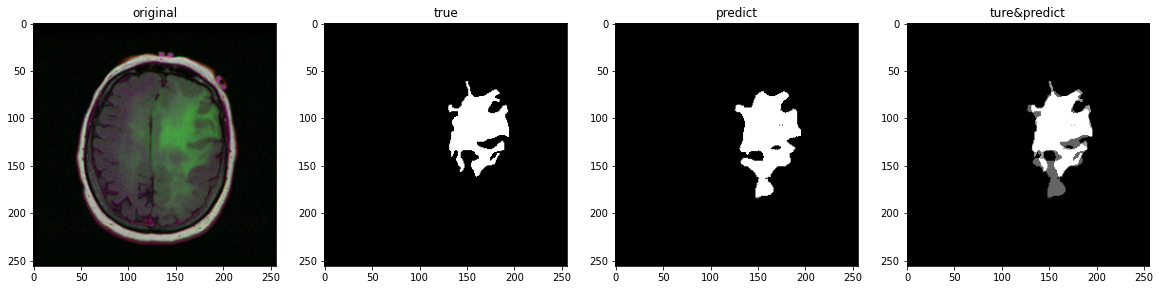

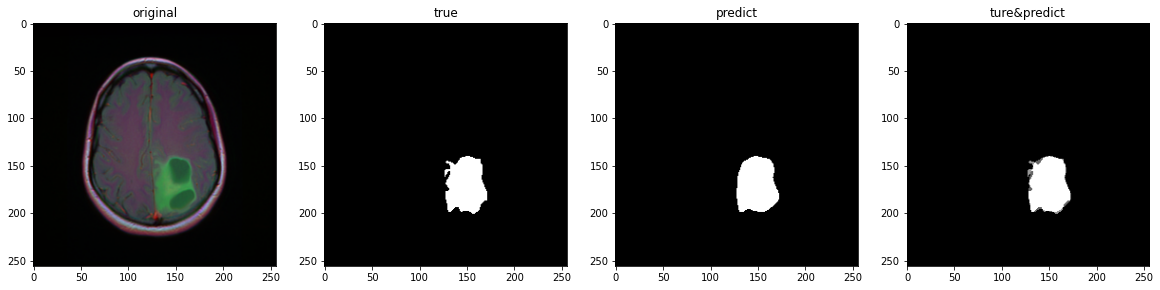

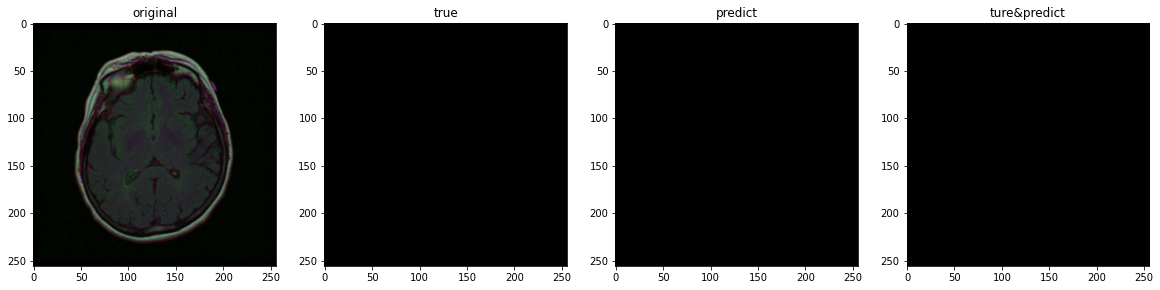

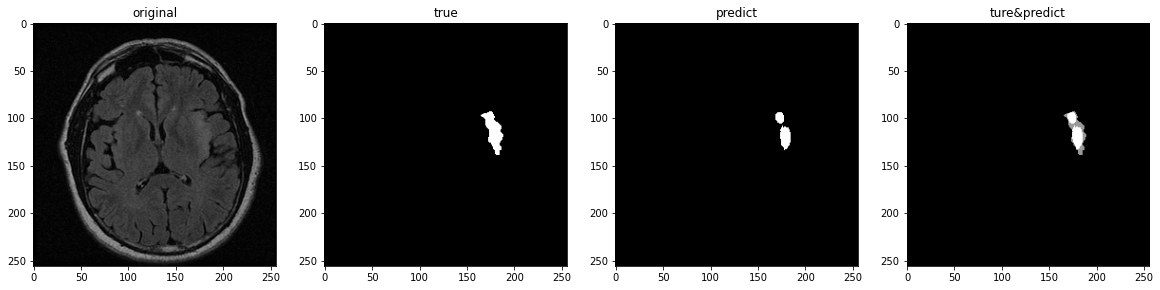

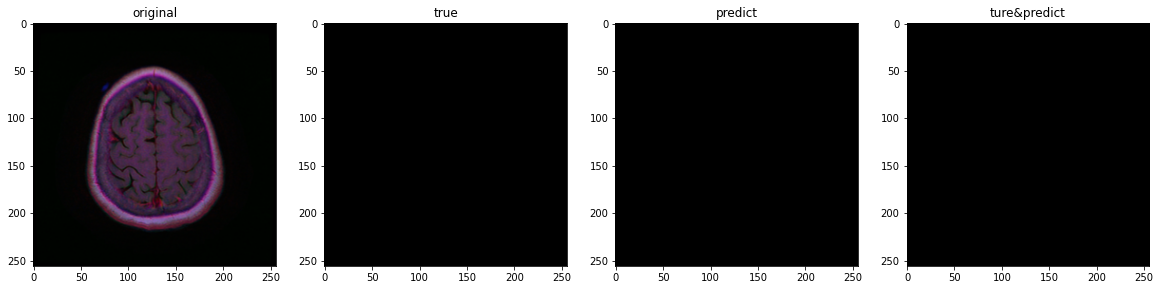

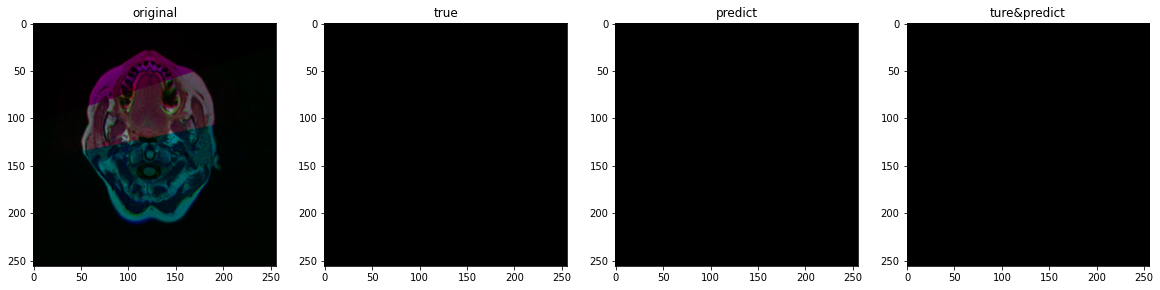

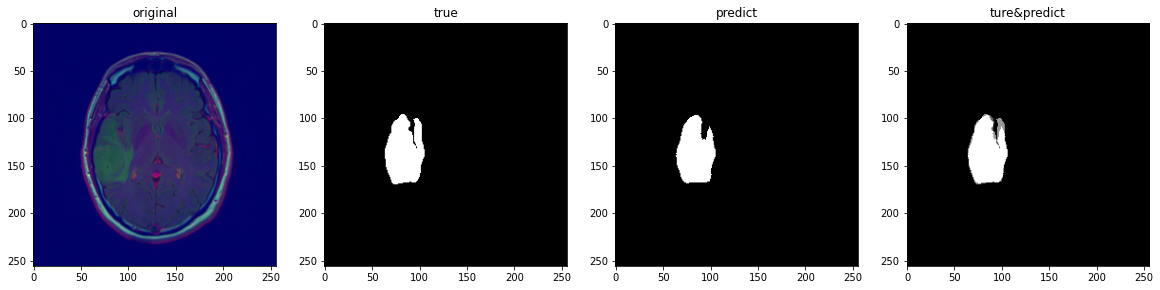

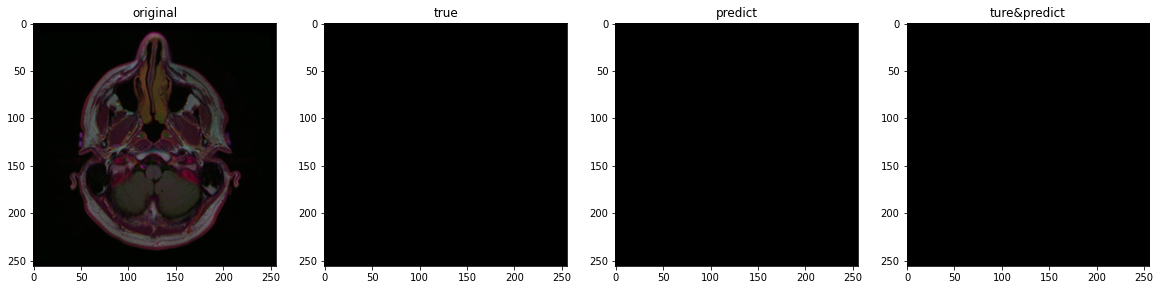

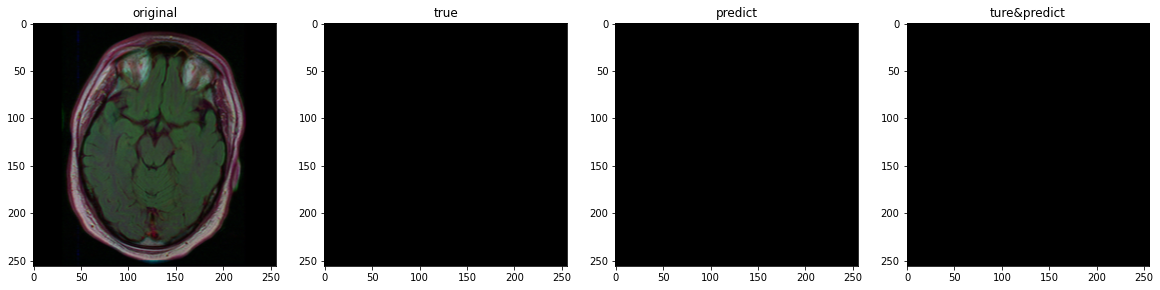

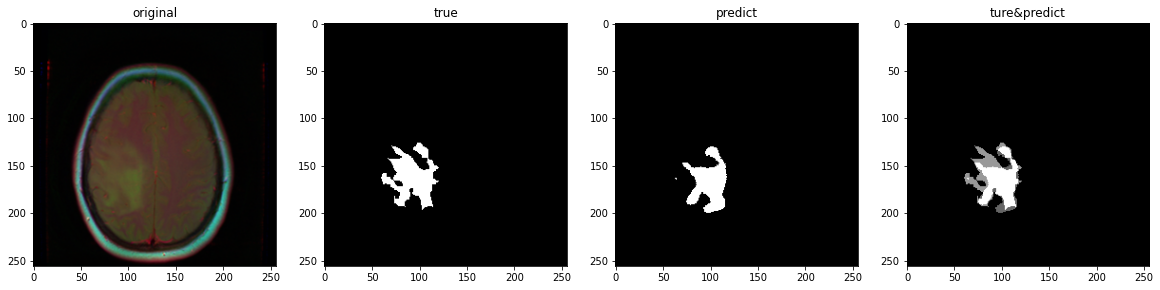

In [96]:
for N in range(10):
    plt.figure(figsize=(20,20))
    plt.subplot(1,4,1)
    img=cv2.imread(test_img[N])
    plt.title("original")
    plt.imshow(img)
    plt.subplot(1,4,2)
    plt.title("true")
    plt.imshow(true_pic[N])
    plt.subplot(1,4,3)
    plt.title("predict")
    plt.imshow(pre[N])
    plt.subplot(1,4,4)
    plt.title("ture&predict")
    plt.imshow(true_pic[N])
    plt.imshow(pre[N],alpha=0.4,cmap="jet")

In [97]:
epoch = np.arange(1,31).reshape(30,1)

In [98]:
test_miou_epoch

[0.718156903584073,
 0.7509743180444107,
 0.7266129392736603,
 0.770915557568105,
 0.7864702367339537,
 0.7732657636145722,
 0.8105457692206098,
 0.8013299197639284,
 0.8171487163149714,
 0.8076935285111367,
 0.8092648481268541,
 0.8042558204050338,
 0.8010171403392916,
 0.8134748402199451,
 0.7889647305653658,
 0.8091616305109843,
 0.8160628841052214,
 0.8154936580120489,
 0.8087876670030104,
 0.8091294636581613,
 0.7669722546080883,
 0.8026135945862679,
 0.8194018351431043,
 0.8069120473526241,
 0.8271209014309163,
 0.8227280427851141,
 0.686300874524941,
 0.8203016208137256,
 0.8131203500381355,
 0.8137610195465653]

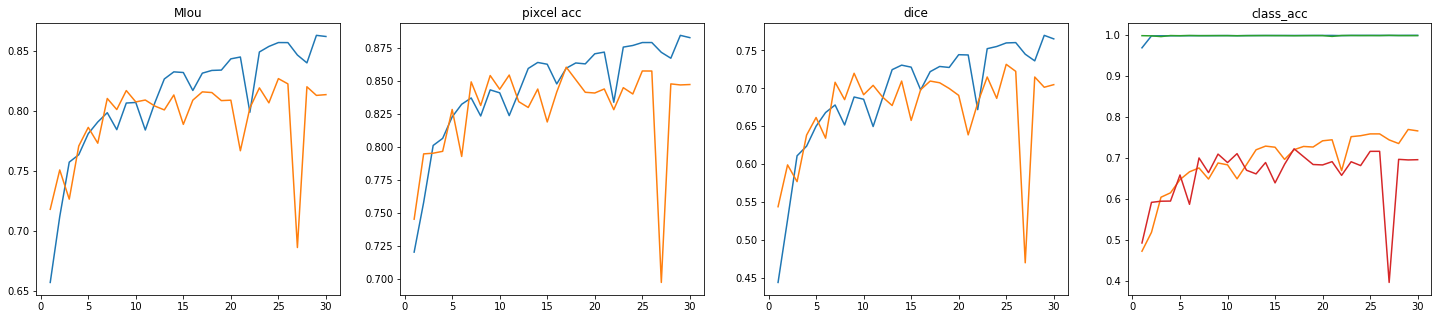

In [99]:
plt.figure(figsize=(25,5))
plt.subplot(1,4,1)
plt.plot(epoch,train_miou_epoch)
plt.plot(epoch,test_miou_epoch)
plt.title("MIou")
plt.subplot(1,4,2)
plt.plot(epoch,train_acc_epoch)
plt.plot(epoch,test_acc_epoch)
plt.title("pixcel acc")
plt.subplot(1,4,3)
plt.plot(epoch,train_dice_epoch)
plt.plot(epoch,test_dice_epoch)
plt.title("dice")
plt.subplot(1,4,4)
plt.plot(epoch,train_class_acc_epoch)
plt.plot(epoch,test_class_acc_epoch)
plt.title("class_acc")
plt.show()

In [101]:
np.savetxt("train_miou_epoch.txt", train_miou_epoch)
np.savetxt("train_acc_epoch.txt", train_acc_epoch)
np.savetxt("train_dice_epoch.txt", train_dice_epoch)
np.savetxt("train_class_acc_epoch.txt", train_class_acc_epoch)

In [102]:
np.savetxt("test_miou_epoch.txt", test_miou_epoch)
np.savetxt("test_acc_epoch.txt", test_acc_epoch)
np.savetxt("test_dice_epoch.txt", test_dice_epoch)
np.savetxt("test_class_acc_epoch.txt", test_class_acc_epoch)